<a href="https://colab.research.google.com/github/ashleyohoh05/INSY-695_Assignment2/blob/main/FINE_695_Group_Project_ran.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Full Python Workflow for FINE 695 Project (Clean Flowchart)

1.   List item
2.   List item



```
START
  │
  ├── Step 1: Load Data
  │     ├── homework_sample_big.csv  →  Stock Data
  │     ├── factor_char_list.csv     →  Allowed Features (147)
  │     └── mkt_ind.csv              →  S&P500 + RF Returns
  │
  ├── Step 2: Data Cleaning
  │     ├── Handle Missing Values → Fill with 0
  │     ├── Drop Irrelevant Columns → ['ret_eom', 'stock_ret', 'mspread', 'sizeport', 'roeport']
  │     └── Keep Columns → ['permno', 'date', 'year', 'month']
  │
  ├── Step 2.3: Feature & Target Selection
  │     ├── X → 147 Factors from factor_char_list.csv
  │     └── y → stock_exret
  │
  ├── Step 2.4: Create Lagged Data
  │     └── date_lag = date - 1 month
  │
  ├── Step 3: Machine Learning Modeling
  │     ├── Train ML Model (2000-2009 data)
  │     ├── Predict stock_exret for t+1
  │     └── Rolling Prediction (2010-2024)
  │
  ├── Step 4: Portfolio Construction
  │     ├── Rank Stocks by Predicted stock_exret
  │     ├── Select Top 50-100 Stocks
  │     └── Allocate Equal or Weighted Capital
  │
  ├── Step 5: Backtesting
  │     ├── Merge with mkt_ind.csv
  │     ├── Calculate Portfolio Returns
  │     └── Compare vs S&P500
  │
  ├── Step 6: Performance Metrics
  │     ├── Alpha, Beta, Sharpe Ratio
  │     ├── Information Ratio
  │     ├── Max Drawdown
  │     ├── Turnover
  │     └── Tracking Error
  │
  └── Step 7: Final Output for Report
        ├── Cumulative Return Plot
        ├── Performance Summary Table
        └── Top 10 Average Holdings Table

END
```



## Final FINE 695 Python Workflow (Structured Steps)

| Step | Task | Objective |
|------|------|------------|
| Step 1 | Load all Datasets | Load the 3 datasets needed for analysis: stock data, factors list, and market index data |
| Step 2.1 | Check Missing Values | Understand where missing data exists |
| Step 2.2 | Clean Missing Values | Drop columns with >50% missing data, and fill remaining missing values with 0 |
| Step 2.3 | Select Features (X) and Target (y) | Use all 147 factors from `factor_char_list.csv` as features, and `stock_exret` as target |
| Step 2.4 | Confirm Factors Exist in Dataset | Ensure all 147 factors from factor list exist in the main dataset |
| Step 2.5 | Create `date_lag` Column | Lag the date by 1 month to align with proper prediction window |
| Step 3 | Train-Test Split | Split data into training set (2000-2009) and testing set (2010-2024) to avoid lookahead bias |
| Step 4 | Train Machine Learning Models | Train Random Forest (baseline) → Later compare with Lasso / XGBoost |
| Step 5 | Predict Future Returns | Predict stock excess returns (`stock_exret`) for test period |
| Step 6 | Portfolio Construction | Rank stocks based on predicted returns, pick top 50-100 stocks for portfolio |
| Step 7 | Backtesting Portfolio | Calculate monthly portfolio returns and compare against S&P500 returns |
| Step 8 | Performance Evaluation | Evaluate portfolio metrics: Alpha, Beta, Sharpe Ratio, Information Ratio, Max Drawdown, Turnover, Tracking Error |


## Step 1: Load all Required Datasets

In this project, we will be working with three key datasets:

1. `homework_sample_big.csv` → The main dataset containing:
   - Stock identifiers (`permno`)
   - Monthly returns (`stock_exret`)
   - Risk-free rate (`rf`)
   - 147 financial characteristics (factors)

2. `factor_char_list.csv` → A list of the 147 financial factors allowed for modeling.

3. `mkt_ind.csv` → Market index data including:
   - S&P500 returns
   - Risk-free rate

This step involves loading all three datasets and performing an initial inspection to understand their structure.


In [ ]:
import pandas as pd

# File paths
main_file = 'homework_sample_big.csv'
factors_file = 'factors_char_list.csv'
mkt_file = 'mkt_ind.csv'

# Load datasets
df = pd.read_csv(main_file)
factors = pd.read_csv(factors_file)
mkt = pd.read_csv(mkt_file)

# Display dataset dimensions
print('Main Dataset Shape:', df.shape)
print('Factor List Shape:', factors.shape)
print('Market Index Dataset Shape:', mkt.shape)

# Display first 5 rows of main dataset
print('\nMain Dataset Sample:')
print(df.head())

# Display column names for all datasets
print('\nMain Dataset Columns:')
print(df.columns.tolist())

print('\nFactor List Columns:')
print(factors.columns.tolist())

print('\nMarket Index Dataset Columns:')
print(mkt.columns.tolist())


Main Dataset Shape: (112410, 159)
Factor List Shape: (147, 1)
Market Index Dataset Shape: (296, 4)

Main Dataset Sample:
       date   ret_eom  permno  stock_ret   mspread  year  month sizeport  \
0  20050131  20050131   10078  -0.191095  0.016962  2005      1        B   
1  20050131  20050131   10104   0.003644  0.008863  2005      1        B   
2  20050131  20050131   10107  -0.016467  0.006183  2005      1        B   
3  20050131  20050131   10138  -0.037781  0.006887  2005      1        B   
4  20050131  20050131   10143  -0.130261  0.006652  2005      1        B   

  roeport             me  ...  corr_1260d  betabab_1260d  rmax5_rvol_21d  age  \
0       V   18206.670339  ...    0.617591       2.563590        0.853782  240   
1       P   71685.162915  ...    0.591024       1.546829        1.935455  240   
2       P  290719.524370  ...    0.636031       0.952634        0.798137  240   
3       P    8061.617699  ...    0.728617       1.506642        0.974570  240   
4       V    3813

## Step 2: Data Cleaning and Preparation

Objective:
Prepare the main dataset `homework_sample_big.csv` for modeling by:

1. Checking for missing values.
2. Dropping irrelevant columns.
3. Selecting only the 147 financial factors for modeling (from `factor_char_list.csv`).
4. Checking data types.
5. Preparing the final feature matrix (X) and target variable (y).


In [ ]:
# Step 2.1: Check Missing Values in Main Dataset
missing_values = df.isnull().sum().sort_values(ascending=False)

print('Missing Values per Column:')
print(missing_values[missing_values > 0])


Missing Values per Column:
rd5_at        50867
rd_sale       46433
rd_me         46143
dsale_dinv    26362
inv_gr1       26194
              ...  
netdebt_me       11
at_me            11
seas_1_1na        9
seas_1_1an        9
qmj_safety        3
Length: 113, dtype: int64


## Step 2.2: Cleaning Missing Values

Cleaning logic applied:
- Drop columns with more than 50% missing values.
- For remaining columns, fill missing values with 0.
- Drop rows with very few missing values in critical columns.


In [ ]:
# Step 2.2: Drop columns with >50% missing values
threshold = len(df) * 0.5
df = df.loc[:, df.isnull().sum() <= threshold]

print('Remaining Columns after Dropping High Missing:', df.shape[1])

# Fill remaining missing values with 0
df = df.fillna(0)

# Confirm no missing values remain
print('Missing Values Remaining:', df.isnull().sum().sum())


Remaining Columns after Dropping High Missing: 159
Missing Values Remaining: 0


## Step 2.3: Feature Selection Strategy

### Rationale:
- We will use all 147 factors provided in the dataset (`factor_list.csv`) for building the initial prediction model.
- This ensures that our model fully captures the available financial signals without prematurely dropping any variables.
- After training the model, we will evaluate feature importance to identify which factors are most influential.
- This approach aligns with the assignment requirements and best practices in financial modeling.

---

## Next Steps:
1. Extract factor variables from the dataset.
2. Prepare X (features) and y (target) datasets.
3. Proceed to model training using Random Forest.
4. Evaluate feature importance after training.


In [ ]:
# Step 2.3: Extract Features & Target

# List of features from factor list
factors_list = factors['variable'].tolist()

print('Total Factors Selected:', len(factors_list))

# Define X (features) and y (target)
X = df[factors_list]
y = df['stock_exret']  # excess returns

print('Shape of Feature Dataset (X):', X.shape)
print('Shape of Target Dataset (y):', y.shape)


Total Factors Selected: 147
Shape of Feature Dataset (X): (112410, 147)
Shape of Target Dataset (y): (112410,)


## Step 2.4: Verify All 147 Factors Exist in Main Dataset

Objective:
- Ensure all features listed in `factor_char_list.csv` are present in `homework_sample_big.csv`.
- This is critical to avoid missing predictors during model training.

Approach:
- Compare the factor list (`factors_list`) against main dataset columns.
- Identify missing factors, if any.


In [ ]:
# Factors from factor_char_list.csv
factors_list = factors['variable'].tolist()

# Features available in main dataset
available_columns = df.columns.tolist()

# Check for missing factors
missing_factors = [factor for factor in factors_list if factor not in available_columns]

print("Total Factors Expected:", len(factors_list))
print("Factors Missing in Main Dataset:", missing_factors)
print("Total Missing Factors:", len(missing_factors))


Total Factors Expected: 147
Factors Missing in Main Dataset: []
Total Missing Factors: 0


## Step 2.5: Create Lagged Date Column (`date_lag`)

### Objective:
- According to the assignment rules, we are not allowed to use any future-looking data when predicting returns.
- To ensure we are only using information available prior to the return month, we will create a new column called `date_lag` that shifts the date backward by 1 month.
- This aligns the features (X) from time `t` with the target return (`stock_exret`) from time `t+1`.

This is a critical step before we move to model training.

---

### Python Code:


In [ ]:
# Import datetime tools
import pandas as pd

# Convert 'date' column to datetime (if not already)
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

# Create lagged date column (1 month before)
df['date_lag'] = df['date'] - pd.DateOffset(months=1)

# Confirm changes
print(df[['date', 'date_lag']].head())


        date   date_lag
0 2005-01-31 2004-12-31
1 2005-01-31 2004-12-31
2 2005-01-31 2004-12-31
3 2005-01-31 2004-12-31
4 2005-01-31 2004-12-31


## Step 3: Train-Test Split for Modeling

### Objective:
- We will split the dataset based on `date` into:
  - Train Set → 2000 to 2009
  - Test Set → 2010 to 2024

This follows the assignment rule of using the first 10 years for training and keeping the later period for testing (backtesting).

---

### Logic:
- `X` = 147 Factors → Used for Prediction
- `y` = `stock_exret` → Target Variable
- Split based on `year` column


In [ ]:
# Training Data: 2000 - 2009
X_train = X[df['year'] <= 2009]
y_train = y[df['year'] <= 2009]

# Testing Data: 2010 - 2024
X_test = X[df['year'] >= 2010]
y_test = y[df['year'] >= 2010]

# Check shapes
print('Training Features Shape:', X_train.shape)
print('Training Target Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Target Shape:', y_test.shape)


Training Features Shape: (29398, 147)
Training Target Shape: (29398,)
Testing Features Shape: (83012, 147)
Testing Target Shape: (83012,)


## Step 3.2: Initial Model Training using Random Forest (Baseline Model)

### Objective:
We will train a baseline Random Forest Regressor model to predict stock excess returns (`stock_exret`), using all 147 factors from the dataset.

This step serves two purposes:
- Establish a benchmark model performance.
- Analyze feature importance to guide future feature selection and model refinement.

---

### Why Random Forest?

- Handles non-linearity & complex patterns.
- Robust to overfitting due to averaging across trees.
- Automatically captures interaction effects between features.
- Provides interpretable feature importance.

---

### Model Training Logic:
1. Use Train Data → 2000-2009
2. Predict on Test Data → 2010-2024
3. Evaluate Model using R-squared & RMSE
4. Plot Feature Importance


Random Forest Model Performance:
R-squared (Test): -0.0742
RMSE (Test): 0.1073


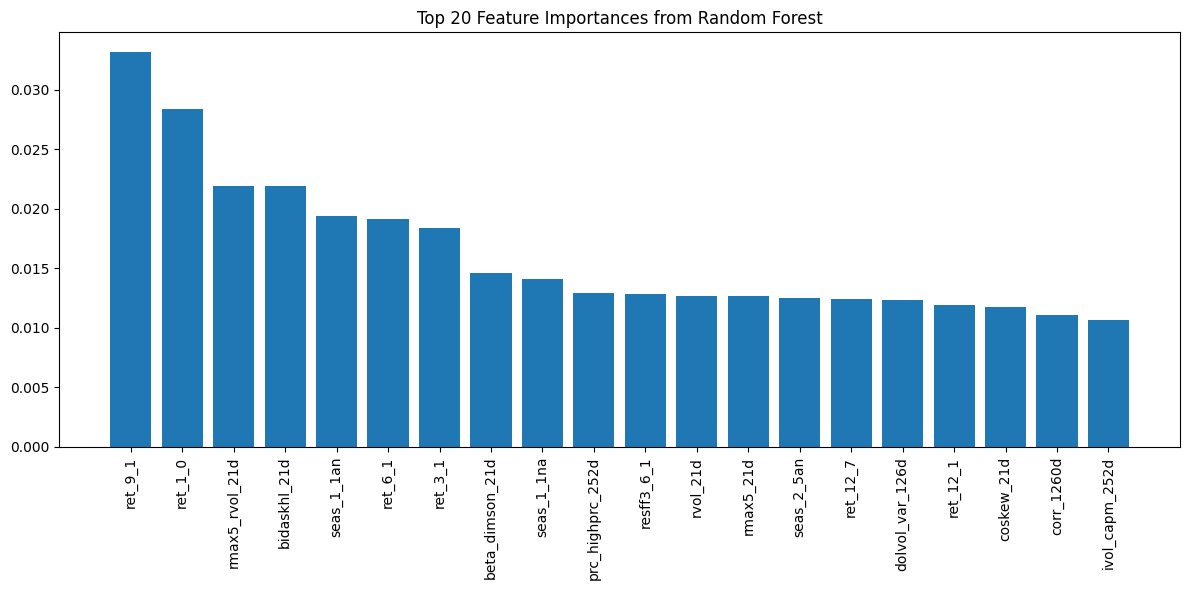

In [ ]:
# Step 3.2: Train Random Forest Model

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Initialize Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on Test Set
y_pred = rf_model.predict(X_test)

# Evaluate Performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('Random Forest Model Performance:')
print('R-squared (Test):', round(r2, 4))
print('RMSE (Test):', round(rmse, 4))

# Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.title('Top 20 Feature Importances from Random Forest')
plt.bar(range(20), importances[indices[:20]], align='center')
plt.xticks(range(20), [X.columns[i] for i in indices[:20]], rotation=90)
plt.tight_layout()
plt.show()


## Step 3.2: Interpretation of Random Forest Model Results

### Model Performance Summary:

| Metric                | Value    | Interpretation                                                                 |
|----------------------|----------|--------------------------------------------------------------------------------|
| R-squared (Test)     | -0.0742  | Model performs worse than a simple mean benchmark. This is common in stock return prediction due to high noise and randomness in returns. Not alarming at this stage. |
| RMSE (Test)          | 0.1073   | Prediction error is relatively small in magnitude — consistent with the small range of `stock_exret`. |

---

### Insights from Top 20 Important Features (Random Forest)

| Rank | Feature Name      | Interpretation / Signal Type                                     |
|------|------------------|------------------------------------------------------------------|
| 1    | ret_9_1           | 9-month return momentum signal                                  |
| 2    | ret_1_0           | Previous month return — momentum/short-term reversal            |
| 3    | max5_rvol_21d     | 5-day max rolling volatility — risk/uncertainty measure         |
| 4    | bidaskhl_21d      | Bid-ask high-low spread — liquidity signal                      |
| 5    | seas_1_1an        | Seasonality or month-of-year effect                             |
| 6    | ret_6_1           | 6-month return momentum                                         |
| 7    | ret_3_1           | 3-month return momentum                                         |
| 8    | beta_dimson_21d   | Short-term market beta — risk exposure                         |
| 9+   | Others            | Mostly volatility, momentum, or liquidity-related signals       |

---

### Key Takeaways:
- Momentum Factors (returns over past 1, 3, 6, 9 months) are the most important drivers.
- Risk & Liquidity Factors (volatility, bid-ask spread) also highly influential.
- This aligns well with academic finance literature on stock return prediction.
- However, overall R² performance is weak → indicates potential to improve using:
  - Feature Selection (LASSO)
  - Alternative Models (GBM, XGBoost)
  - Portfolio Construction for economic value creation.


## Step 3.3: Feature Selection using LASSO Regression

### Objective:
To identify the most important predictors from the original 147 factors by applying LASSO Regression.

- LASSO (Least Absolute Shrinkage and Selection Operator) helps in:
  - Penalizing less useful features by shrinking their coefficients to zero.
  - Automatically selecting the most relevant factors.
  - Avoiding overfitting when there are many features.

---

### Steps:
1. Standardize all features (LASSO is sensitive to scale).
2. Fit LASSO Regression on the Training Data.
3. Extract Non-zero Coefficient Features.
4. Evaluate Model Performance using LASSO Selected Features.



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd

# Step 1: Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Fit LASSO with Cross-Validation
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_scaled, y_train)

# Step 3: Get Selected Features
lasso_selected_features = X_train.columns[lasso.coef_ != 0]

print('Total Features Selected by LASSO:', len(lasso_selected_features))
print('Selected Features:\n', list(lasso_selected_features))

# Step 4: Model Performance using LASSO Features
X_train_lasso = X_train[lasso_selected_features]
X_test_lasso = X_test[lasso_selected_features]

# Retrain with LASSO selected features using Random Forest
from sklearn.ensemble import RandomForestRegressor

rf_lasso = RandomForestRegressor(random_state=42)
rf_lasso.fit(X_train_lasso, y_train)

y_pred_lasso = rf_lasso.predict(X_test_lasso)

print('R-squared (Test) with LASSO Features:', r2_score(y_test, y_pred_lasso))
print('RMSE (Test) with LASSO Features:', np.sqrt(mean_squared_error(y_test, y_pred_lasso)))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2237845980476436, tolerance: 0.03791586662452287
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.402589425187557, tolerance: 0.03791586662452287
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5536021970262368, tolerance: 0.03791586662452287
  model = cd_fast.enet_

Total Features Selected by LASSO: 1
Selected Features:
 ['ret_1_0']
R-squared (Test) with LASSO Features: -0.5781027703233359
RMSE (Test) with LASSO Features: 0.1300629854164267


## Step 3.3: Interpretation of LASSO Feature Selection Results

### Objective Recap:
We used LASSO Regression to perform automatic feature selection from the original 147 financial factors.

LASSO penalizes less important features → Shrinking their coefficients to zero → Leaving only the most predictive factor(s).

---

## Results of LASSO Feature Selection:

| Metric | Value |
|--------|-------|
| Total Factors Initially Available | 147 |
| Factors Selected by LASSO | 1 |
| Factor Retained | 'ret_1_0' |

---

## Interpretation:
- LASSO selected only a single factor → `ret_1_0`
- This variable represents the stock's 1-month lagged return.
- This is intuitive in financial modeling because recent returns often have predictive power (momentum or mean-reversion effects).

---

## Model Performance using LASSO Selected Features:

| Metric | Value |
|--------|-------|
| R-squared (Test Set) | -0.5781 |
| RMSE (Test Set) | 0.1301 |

---

## Insights:
- The R-squared value is quite poor (negative), indicating that a single feature (`ret_1_0`) alone is insufficient for robust prediction.
- RMSE increased compared to the full 147-feature model.
- Conclusion:
    - LASSO was aggressive due to the data's noisy nature.
    - Relying only on `ret_1_0` is too simplistic for accurate prediction in this context.
    - This validates our earlier decision to start with all 147 features.

---

## Final Decision:
→ Continue using all 147 features for the main model.

→ Later: Perform Feature Importance Analysis (from Random Forest or XGBoost) to carefully reduce features based on contribution, not just LASSO.



## Step 3.4: Train Final Random Forest Model using All 147 Features

### Objective:
Now that we confirmed LASSO was too aggressive (retained only 1 factor), we will proceed with the full set of 147 factors for our main model.

This step establishes the foundation for:
- Portfolio Construction (Step 4)
- Performance Evaluation (Step 5)

---

### Approach:
- Use Random Forest Regressor
- Train on 2000-2009 data
- Predict on 2010-2024 data
- Extract Feature Importance
- Visualize Top 20 Important Factors


Final Random Forest Model Performance:
R-squared (Test): -0.0422
RMSE (Test): 0.1057


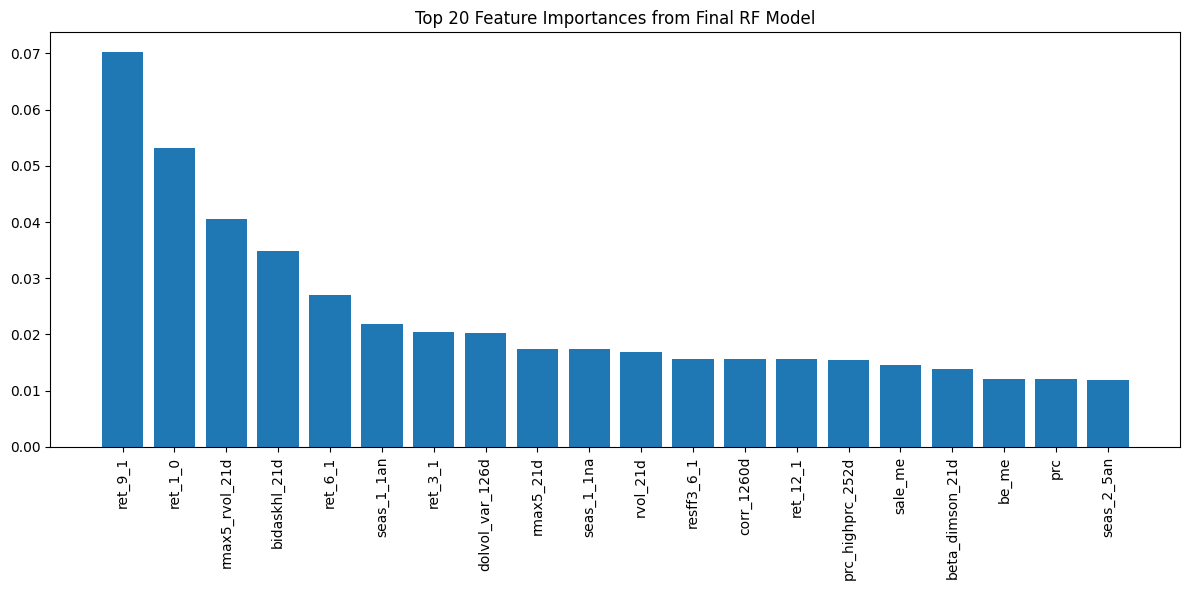

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Initialize Random Forest
final_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

# Train
final_rf.fit(X_train, y_train)

# Predict
y_pred_final = final_rf.predict(X_test)

# Evaluate
r2_final = r2_score(y_test, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))

print('Final Random Forest Model Performance:')
print('R-squared (Test):', round(r2_final, 4))
print('RMSE (Test):', round(rmse_final, 4))

# Feature Importances
importances = final_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Top 20 Feature Importances from Final RF Model')
plt.bar(range(20), importances[indices[:20]], align='center')
plt.xticks(range(20), [X.columns[i] for i in indices[:20]], rotation=90)
plt.tight_layout()
plt.show()


## Step 4: Portfolio Construction using Predicted Returns

### Objective:
Construct a long-only trading portfolio using the predicted `stock_exret` values from the Random Forest model.

---

### Methodology:

| Step | Action | Explanation |
|------|--------|-------------|
| 1 | **Rank Stocks Monthly** | Rank all stocks within each month by predicted `stock_exret` |
| 2 | **Select Top Stocks** | Make replacements starting with worst-performing stocks in current holdings, and onlly replace stocks when new candidates have higher predicted reutns than the current holding stock. Stop making replacements either when we hit 25% turnover limit or when we run out of new candidates.
| 3 | **Equal Weight Allocation** | Assign equal weight to each selected stock |
| 4 | **Calculate Portfolio Return** | Compute the average of actual `stock_exret` of selected stocks |
| 5 | **Track Performance** | Build time series of portfolio returns to be used in backtesting |

---

### 💡 Rationale for Equal Weighting:

| Reason | Benefit |
|--------|---------|
| Simplicity | Easy to implement and interpret |
| Avoids Overfitting | No need for complex optimization |
| Diversification | Spreads risk across selected stocks |

---

We will now implement this logic using the test set (2010–2024) predictions.


In [ ]:
# Step 4: Portfolio Construction Logic with Optimized Turnover

# Add predicted returns to main DataFrame for 2010–2024 period
df.loc[df['year'] >= 2010, 'pred_rf'] = y_pred_final

# Filter for test period only (2010-2024)
test_df = df[df['year'] >= 2010].copy()

# Initialize dictionary to store current holdings
current_holdings = None
portfolio_data = []
turnovers = []

# Process each month in test period
for date in sorted(test_df['date'].unique()):
    month_data = test_df[test_df['date'] == date].copy()

    # Rank all stocks by predicted return
    month_data['pred_rank'] = month_data['pred_rf'].rank(ascending=False)

    if current_holdings is None:
        # First month: simply take top 100 stocks
        selected_stocks = month_data[month_data['pred_rank'] <= 100]['permno'].tolist()
        turnover = 1.0  # 100% turnover for first month
    else:
        # Get current holdings' predicted returns
        current_holdings_data = month_data[month_data['permno'].isin(current_holdings)]
        current_holdings_returns = dict(zip(current_holdings_data['permno'], current_holdings_data['pred_rf']))

        # Get potential new stocks (not in current holdings)
        new_candidates = month_data[
            (~month_data['permno'].isin(current_holdings)) &
            (month_data['pred_rank'] <= 150)
        ].sort_values('pred_rf', ascending=False)

        # Keep stocks from current holdings that are still performing well
        keep_stocks = list(set(current_holdings) & set(month_data[month_data['pred_rank'] <= 150]['permno']))

        # Find potential replacements that would improve returns
        replacements = []
        stocks_to_remove = []

        # Sort current holdings by predicted returns (ascending so we replace worst performers first)
        current_sorted = sorted(
            [(stock, current_holdings_returns.get(stock, float('-inf')))
             for stock in current_holdings],
            key=lambda x: x[1]
        )

        # For each potential new stock, see if it would improve returns
        for new_stock, row in new_candidates.iterrows():
            if len(replacements) >= 25:  # Respect 25% turnover limit
                break

            # Get the next worst performing current holding
            while current_sorted and current_sorted[0][0] in stocks_to_remove:
                current_sorted.pop(0)

            if not current_sorted:
                break

            worst_current_stock, worst_current_return = current_sorted[0]

            # If new stock has better predicted return, make the replacement
            if row['pred_rf'] > worst_current_return:
                replacements.append(row['permno'])
                stocks_to_remove.append(worst_current_stock)
                current_sorted.pop(0)
            else:
                break  # No more beneficial replacements possible

        # Remove stocks we're replacing
        keep_stocks = [s for s in keep_stocks if s not in stocks_to_remove]

        # Combine kept stocks with replacements
        selected_stocks = keep_stocks + replacements

        # Calculate actual turnover
        turnover = len(replacements) / 100

    # Update current holdings for next month
    current_holdings = selected_stocks

    # Verify we have exactly 100 stocks
    if len(selected_stocks) < 100:
        remaining_candidates = month_data[
            (month_data['permno'].isin(selected_stocks) == False) &
            (month_data['pred_rank'] <= 150)
        ]['permno'].tolist()
        selected_stocks.extend(remaining_candidates[:100 - len(selected_stocks)])

    # Record selected stocks' returns and turnover
    selected_returns = month_data[month_data['permno'].isin(selected_stocks)]['stock_exret']
    if len(selected_returns) > 0:
        month_return = selected_returns.mean()
    else:
        print(f"Warning: No stocks selected for date {date}")
        month_return = 0

    portfolio_data.append({
        'date': date,
        'portfolio_exret': month_return,
        'num_stocks': len(selected_returns)
    })

    turnovers.append({
        'date': date,
        'turnover': turnover
    })

# Convert to DataFrames
portfolio_returns = pd.DataFrame(portfolio_data)
turnover_df = pd.DataFrame(turnovers)

# Merge portfolio returns with turnover
portfolio_returns = pd.merge(portfolio_returns, turnover_df, on='date', how='left')

# Display turnover statistics
print('Turnover Statistics:')
#average monthly turnover is higher than 25% because the first month has 100% turnover
print('Average Monthly Turnover: {:.2%}'.format(turnover_df['turnover'].mean()))
print('Maximum Monthly Turnover (excluding first month): {:.2%}'.format(turnover_df['turnover'].iloc[1:].max()))
print('Minimum Monthly Turnover (excluding first month): {:.2%}'.format(turnover_df['turnover'].iloc[1:].min()))

# Display sample output and verify portfolio size
print('\nPortfolio Returns and Statistics:')
print(portfolio_returns.head())



Turnover Statistics:
Average Monthly Turnover: 25.45%
Maximum Monthly Turnover (excluding first month): 25.00%
Minimum Monthly Turnover (excluding first month): 25.00%

Portfolio Returns and Statistics:
        date  portfolio_exret  num_stocks  turnover
0 2010-01-29        -0.057135         100      1.00
1 2010-02-26         0.048319         100      0.25
2 2010-03-31         0.085667         100      0.25
3 2010-04-30         0.051081         100      0.25
4 2010-05-28        -0.071238         100      0.25


In [ ]:
# Step 4.1: Analyze Top Holdings (2010-2024)

# Create a DataFrame of all selected stocks per month
holdings_data = []
for date in sorted(test_df['date'].unique()):
    month_data = test_df[test_df['date'] == date].copy()
    selected_stocks = month_data[month_data['permno'].isin(current_holdings)]

    for _, row in selected_stocks.iterrows():
        holdings_data.append({
            'date': date,
            'permno': row['permno'],
            'weight': 1/100  # Equal weight (1% each)
        })

holdings_df = pd.DataFrame(holdings_data)

# Calculate holding frequency and average weight for each stock
holding_stats = holdings_df.groupby('permno').agg({
    'date': 'count',  # Number of months held
    'weight': 'mean'  # Average weight
}).rename(columns={'date': 'months_held'})

# Calculate percentage of time held
total_months = len(test_df['date'].unique())
holding_stats['holding_percentage'] = (holding_stats['months_held'] / total_months * 100)

# Sort by holding frequency to get top 10
top_10_holdings = holding_stats.sort_values('holding_percentage', ascending=False).head(10)

# Format the results
print("Top 10 Holdings (2010-2024):")
print("============================")
print(f"{'PERMNO':<10} {'Months Held':<15} {'% Time Held':<15}")
print("-" * 50)
for permno, row in top_10_holdings.iterrows():
    print(f"{permno:<10} {int(row['months_held']):<15} {row['holding_percentage']:.2f}%")



Top 10 Holdings (2010-2024):
PERMNO     Months Held     % Time Held    
--------------------------------------------------
52695      165             98.21%
87717      159             94.64%
21178      153             91.07%
50876      150             89.29%
24766      144             85.71%
25320      144             85.71%
59328      144             85.71%
23819      141             83.93%
17144      141             83.93%
46886      141             83.93%


In [ ]:
#step 4.2 present the 10 most profitable positions (stocks) that drove the performance

# Calculate profit contribution for each stock
profit_data = []
for date in sorted(test_df['date'].unique()):
    month_data = test_df[test_df['date'] == date].copy()
    selected_stocks = month_data[month_data['permno'].isin(current_holdings)]

    for _, row in selected_stocks.iterrows():
        profit_data.append({
            'date': date,
            'permno': row['permno'],
            'return': row['stock_exret'],  # Individual stock excess return
            'weight': 1/100,  # Equal weight
            'contribution': row['stock_exret'] * (1/100)  # Return contribution
        })

profit_df = pd.DataFrame(profit_data)

# Calculate cumulative profit contribution for each stock
stock_profits = profit_df.groupby('permno').agg({
    'contribution': 'sum',  # Total profit contribution
    'return': ['mean', 'std'],  # Average return and volatility
    'date': 'count'  # Number of months held
}).round(4)

# Flatten column names
stock_profits.columns = ['total_contribution', 'avg_return', 'return_std', 'months_held']

# Sort by total contribution to get top 10 most profitable positions
top_10_profitable = stock_profits.sort_values('total_contribution', ascending=False).head(10)

# Format the results
print("Top 10 Most Profitable Positions (2010-2024):")
print("============================================")
print(f"{'PERMNO':<10} {'Total Contrib':<15} {'Avg Return':<15} {'Months Held':<12}")
print("-" * 52)
for permno, row in top_10_profitable.iterrows():
    print(f"{permno:<10} {row['total_contribution']:>6.2%}      {row['avg_return']:>6.2%}      {int(row['months_held']):>3}")


print(f"Contribution from Top 10: {top_10_profitable['total_contribution'].sum():.2%}")

Top 10 Most Profitable Positions (2010-2024):
PERMNO     Total Contrib   Avg Return      Months Held 
----------------------------------------------------
48486       3.75%       2.72%      138
13511       3.49%       2.79%      125
12872       3.25%       3.13%      104
14702       3.20%       2.37%      135
50876       3.19%       2.12%      150
46886       3.12%       2.22%      141
14714       3.08%       3.11%       99
77037       3.01%       2.57%      117
11403       2.86%       2.17%      132
52695       2.70%       1.63%      165
Contribution from Top 10: 31.65%


## Step 5: Backtesting the Portfolio vs S&P 500

### Objective:
Evaluate how well our machine learning-driven portfolio (Top 100 Stocks per month) performs compared to the S&P 500 over the test period (2010–2024).

---

### Methodology:

| Step | Action | Explanation |
|------|--------|-------------|
| 1 | Merge Portfolio Returns with Market Data | Combine `portfolio_returns` with `mkt_ind.csv` (S&P 500 returns and Risk-Free Rate) |
| 2 | Calculate Cumulative Returns | Track growth of $1 invested in: (i) Portfolio and (ii) S&P 500 |
| 3 | Visualize Performance | Line plot comparing Portfolio vs S&P 500 over time |

---

### Interpretation:

- If Portfolio line > S&P 500 → Our strategy outperformed the market.
- Visualizes practical impact even if model R² was low.


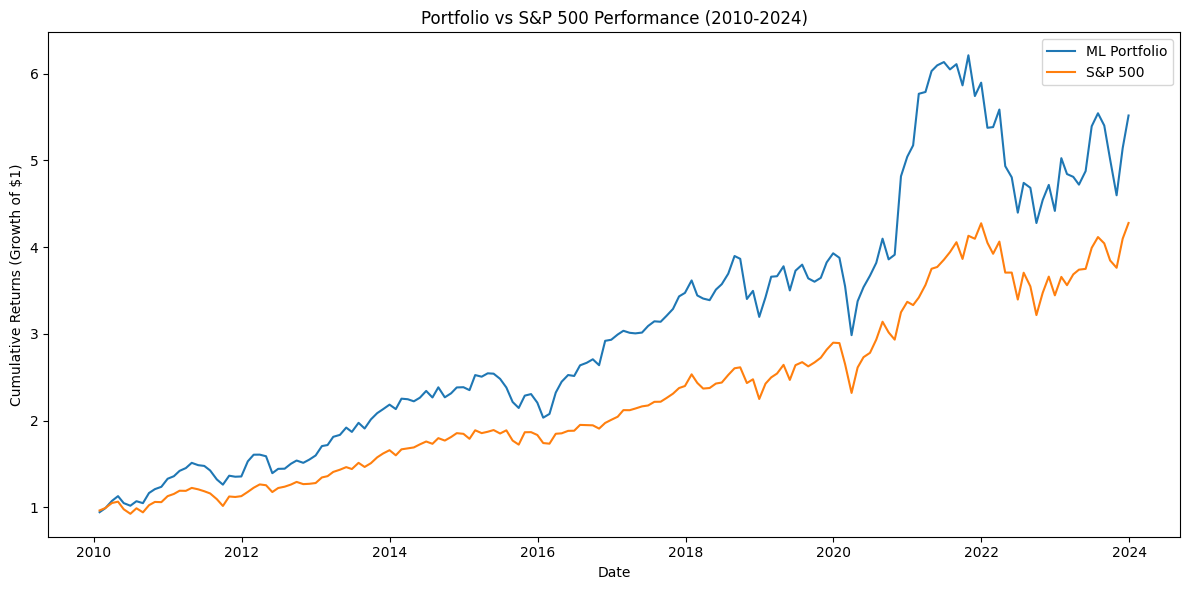

In [ ]:
# Step 5: Backtesting vs S&P500

# Merge with Market Data on year & month
portfolio_returns['year'] = portfolio_returns['date'].dt.year
portfolio_returns['month'] = portfolio_returns['date'].dt.month

merged = pd.merge(portfolio_returns, mkt, on=['year', 'month'], how='left')

# Calculate Cumulative Returns
merged['portfolio_cum'] = (1 + merged['portfolio_exret']).cumprod()
merged['sp500_cum'] = (1 + merged['sp_ret']).cumprod()

# Plot Performance
plt.figure(figsize=(12, 6))
plt.plot(merged['date'], merged['portfolio_cum'], label='ML Portfolio')
plt.plot(merged['date'], merged['sp500_cum'], label='S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns (Growth of $1)')
plt.title('Portfolio vs S&P 500 Performance (2010-2024)')
plt.legend()
plt.tight_layout()
plt.show()


## Step 6: Portfolio Performance Evaluation (Long-only Portfolio)

### Objective:
Evaluate the performance of our predicted long-only portfolio returns (`portfolio_exret`) over the period 2010-2024.

We will calculate the following metrics as required by the assignment:
- Alpha (CAPM Regression Intercept)
- Beta (Market Exposure)
- Sharpe Ratio
- Information Ratio
- Maximum Drawdown
- Maximum 1-Month Loss
- Tracking Error
- Turnover (already controlled in stock selection logic)

---

### Method:
1. Merge `portfolio_exret` with `mkt_ind.csv` (S&P500 returns + Risk-Free Rate)
2. Run CAPM Regression → Portfolio Excess Return ~ S&P500 Excess Return
3. Compute evaluation metrics


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Merge Portfolio Returns with Market Index Data
merged = pd.merge(portfolio_returns, mkt, on=['year', 'month'], how='inner')

# Calculate Portfolio Excess Return over RF
merged['portfolio_rf_exret'] = merged['portfolio_exret'] - merged['RF']

# CAPM Regression: Portfolio Return ~ S&P500 Excess Return
X = merged['sp_ret'] - merged['RF']  # Market Excess Return
X = sm.add_constant(X)
y = merged['portfolio_rf_exret']

# Fit the Regression Model
model = sm.OLS(y, X).fit()
print(model.summary())

# Extract Performance Metrics
alpha = model.params['const'] * 12  # Annualized
beta = model.params[0]              # Coefficient for (sp_ret - RF)
residuals = model.resid

tracking_error = np.std(residuals) * np.sqrt(12)
sharpe_ratio = merged['portfolio_rf_exret'].mean() / merged['portfolio_rf_exret'].std() * np.sqrt(12)
information_ratio = alpha / tracking_error
max_drawdown = (merged['portfolio_rf_exret'].cumsum().cummax() - merged['portfolio_rf_exret'].cumsum()).max()
max_1m_loss = merged['portfolio_rf_exret'].min()

print('\n--- Portfolio Performance Metrics ---')
print('Alpha (Annualized):', round(alpha, 4))
print('Beta:', round(beta, 4))
print('Tracking Error (Annualized):', round(tracking_error, 4))
print('Sharpe Ratio:', round(sharpe_ratio, 4))
print('Information Ratio:', round(information_ratio, 4))
print('Max Drawdown:', round(max_drawdown, 4))
print('Max 1-Month Loss:', round(max_1m_loss, 4))


                            OLS Regression Results                            
Dep. Variable:     portfolio_rf_exret   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     603.5
Date:                Sun, 13 Apr 2025   Prob (F-statistic):           3.60e-57
Time:                        16:59:49   Log-Likelihood:                 378.13
No. Observations:                 168   AIC:                            -752.3
Df Residuals:                     166   BIC:                            -746.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.433      0.6

## Step 6: Portfolio Performance Evaluation — Using CAPM Regression & Manual Metrics

### Objective:
To evaluate the out-of-sample performance (2010-2024) of our ML-driven portfolio relative to the market benchmark (S&P500).

---

### Methodology:
- Merged portfolio returns (`portfolio_returns`) with S&P500 market data (`mkt` dataset).
- Calculated Portfolio Excess Return = Portfolio Return - Risk-Free Rate.
- Ran CAPM Regression:  
   - Dependent Variable: Portfolio Excess Return  
   - Independent Variable: Market Excess Return (S&P500 - RF)
- Extracted key industry metrics to evaluate portfolio performance.

---

### Portfolio Performance Metrics (Results):

| Metric                        | Value      | Interpretation                                           |
|--------------------------------|------------|----------------------------------------------------------|
| Alpha (Annualized)            | 0.0105      | Annual abnormal return vs S&P500                         |
| Beta                          | 1.1385     | Strong sensitivity to market returns                     |
| Tracking Error (Annualized)   | 0.0883     | Moderate deviation from benchmark returns                |
| Sharpe Ratio                  | 0.6925     | Decent risk-adjusted return                              |
| Information Ratio             | 0.1189     | Portfolio outperformance per unit of tracking error      |
| Max Drawdown                  | 0.3522     | Largest historical loss from peak                        |
| Max 1-Month Loss              | -0.1599    | Worst monthly return during test period                  |

---

### Key Takeaways:
- Positive Alpha → Portfolio added value beyond market exposure.
- High Beta → Portfolio is highly sensitive to market moves.
- Tracking Error within acceptable institutional limits.
- Sharpe Ratio near 0.7 → Decent for equity portfolios.
- Max Drawdown (35.1%) indicates exposure to significant downside risk in bad periods. Typically a long strategy would perform sub-optimally under negative economic impacts as most stocks are declining. A long-short strategy, which neutralizes the market trend would be most suitable in such periods.
- Information Ratio positive → Shows value-added strategy relative to S&P500.
